# Implementing a Neural Network

In [1]:
%matplotlib inline

In [2]:
import numpy
import pandas
import matplotlib

## Introduction

This walk-through of creating a simple neural network to predict outputs given an input is derived from [Neural Networks from Scratch with Python Code and Math in Detail](https://medium.com/towards-artificial-intelligence/building-neural-networks-from-scratch-with-python-code-and-math-in-detail-i-536fae5d7bbf).  I found that walk-through a bit confusing, so I made this notebook to help me walk through each step and understand it.

Here, we build an extremely simple neural network based on a linear model (a [perceptron](https://en.wikipedia.org/wiki/Perceptron)) that classifies an input as one thing or another based on a couple of input parameters.

Specifically, we're going to create a model of a simple OR gate with two inputs and one output.  OR gates have the following behavior:

1. If both inputs are 0 (off), the output is 0 (off)
2. If both inputs are 1 (on), the output is 1 (on)
3. If either input is 1 (on), the output is still 1 (on)

And we want to create a model, $f(x)$, that takes two inputs ($x$) and returns either a 0 or 1 based on the value of those inputs.

Let's first build a set of observations that capture this behavior as if we were experimenting with an OR gate ourselves:

In [3]:
inputs = pandas.DataFrame(
    [[0, 0],
    [0, 1],
    [1, 0],
    [1, 1]],
    columns=["input 1", "input 2"])
inputs.index.name = "observation #"

ground_truth = pandas.Series([0, 1, 1, 1], name="true output", index=inputs.index)

print("Inputs and true outputs (truth table) are:")
print(pandas.concat((inputs, ground_truth), axis=1))

Inputs and true outputs (truth table) are:
               input 1  input 2  true output
observation #                               
0                    0        0            0
1                    0        1            1
2                    1        0            1
3                    1        1            1


## Defining our model

The model we're using to predict our output values, $f(x, w)$, is based on a linear model $y(x)$ at its core:

$ y = x \cdot w + b $


where

- $x$ are our observed inputs (the _independent_ variables)
- $w$ are empirical "weight" parameters
- $b$ is an empirical "bias" parameter

The magic of this model is in figuring out what values for our empirical parameters, $w$ and $b$, result in the model producing our true outputs for each set of given inputs.

Before we do that though, we have to shove this $y(x)$ through an "activation function" $A(x)$ to make so the model can only return values between 0 (off) and 1 (on) though.  We arbitrarily choose a sigmoid function to accomplish this:

$ A(x) = \frac{1}{1 + e^{-x}} $

Which can be defined in Python as follows:

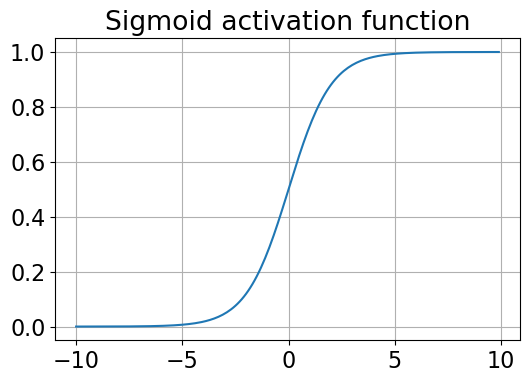

In [4]:
def sigmoid(x):
    """Activation function
    """
    return 1.0 / (1.0 + numpy.exp(-x))

def d_sigmoid(x):
    """First derivative of activation function
    """
    return sigmoid(x) * (1.0 - sigmoid(x))

matplotlib.pyplot.plot(numpy.arange(-10, 10, 0.1), sigmoid(numpy.arange(-10, 10, 0.1)))
matplotlib.pyplot.grid()
matplotlib.pyplot.title("Sigmoid activation function")
pass

Because we're nesting our linear function in an activation function, $f(x, w)$ looks pretty gnarly if you expand it out:

$ f(x, w) = A(y(x)) = A(x \cdot w + b) = \frac{1}{1 + e^{-x \cdot w - b}} $

But I like to really think of our model as $ y = x \cdot w + b $ with some special sauce splashed on top to make sure our output values aren't unbounded.  If we didn't have an activation function, our linear model $y(x)$ would predict values that could go to infinity which

1. doesn't represent the reality of the true outputs (we know that they can only vary from 0 to 1)
2. will cause gradient descent to not _converge_ (approach the right answer) very well

You can confirm this yourself by defining `sigmoid(x)` to just `return x` and `d_sigmoid(x)` to return `1`.

Now that we have a model in mind, we have to figure out how to _parameterize_ to get values for our weights 

## Setting up gradient descent

We have a choice of model (a linear one wrapped in an activation function), so now we need to figure out what values of our empirical parameters $w$ and $b$ should be to make the model produce outputs that most closely track reality.  To do this, we use [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent).  Its formal definition is

$ w_{t+1} = w_t - R \cdot \frac{d}{dw}E(x, w_t) $

where $R$ is the "learning rate," an empirical _hyperparameter_.  Whereas $w$ and $b$ are parameters that relate inputs to outputs, $R$ is a hyperparameter because it doesn't relate to what's being modeled as much as it relates to the model itself.

$E(x, w)$ is a "loss function" that describes how far away our empirical model $f(x, w)$ is from ground truth values $ f_0 $, and the goal of this whole exercise with gradient descent is to minimize the loss, or make the difference between our model and reality as small as possible.

Our first order of business to actually calculate some numbers and evolve our model is to define some starting values of our empirical parameters: weights, bias, and learning rate.  Since our inputs $x$ are actually an array, $w$ must also be an array with one value for each of our input variables in $x$:

In [5]:
print("Setting initial weights to random values.")
weights = numpy.random.rand(inputs.shape[1], 1)

print(pandas.DataFrame(weights, index=inputs.columns, columns=["weight"]))

Setting initial weights to random values.
           weight
input 1  0.239794
input 2  0.309183


Our bias parameter $b$ and learning rate (hyper)parameter $R$ are both scalar values.

We can set the bias to some random value because gradient descent will find its optimal value for us.

Learning rate is a constant that we set--it needs to be small enough for the interative method to not go haywire by skipping around too much between successive iterations, but not so small as to take a gazillion iterations to approach the optimal weights.

In [6]:
bias = numpy.random.rand(1)[0]
print("Setting starting bias to a random value: {:4f}".format(bias))

learning_rate = 0.05
print("Setting learning rate to {} based on prior experience.".format(learning_rate))

Setting starting bias to a random value: 0.343374
Setting learning rate to 0.05 based on prior experience.


## Applying gradient descent

How do we actually _solve_ our gradient descent equation, $ w_{t+1} = w_t - R \cdot \frac{d}{dw}E(x, w_t) $?  That is, how do we train our model?

- We have weights $w_t$ since we randomly defined them above
- We know the form of our model $f(x, w_t)$ since we define it as $ f(x, w) = A \left ( x \cdot w + b \right ) $
- We defined our _learning rate_ $R$ arbitrarily as 0.05 above

So we just need to figure out what $\frac{d}{dw}E(x, w_t)$ is--or how our _loss function_ varies as our _weights_ vary for a given set of input values $x$.

We can pretty arbitrarily define our _loss function_.  This form seems to capture the right idea:

$ E = f_0 - f $

As the difference between our predicted $f$ and ground truth outputs $f_0$ get bigger, our error gets bigger.  Easy.

Then we break apart $\frac{\partial E}{\partial w}$ using the chain rule:

$ \frac{\partial E}{\partial w} =
        \frac{\partial E}{\partial f}
  \cdot \frac{\partial f}{\partial y}
  \cdot \frac{\partial y}{\partial w} $

The derivations of these three components is tedious, so see [Neural Networks from Scratch with Python Code and Math in Detail](https://medium.com/towards-artificial-intelligence/building-neural-networks-from-scratch-with-python-code-and-math-in-detail-i-536fae5d7bbf) if you _really_ care--or apply your college calculus to figure out these derivatives yourself.  They come out to be:

1. $ \frac{\partial E}{\partial f} = f - f_0 $
2. $ \frac{\partial f}{\partial y} = f \left ( 1 - f \right ) $
3. $ \frac{\partial y}{\partial w} = x_0 $

With this, we can just calculate $w_t$ for $t \rightarrow \infty$ using the gradient descent formula above to approach the optimal set of weights that minimize our loss function and thereby produce a model that approximates reality.  So as not to spend infinite time calculating for $t \rightarrow \infty$, we choose $t \rightarrow 10000$:

In [7]:
NUM_EPOCHS = 10000

Then start the gradient descent process to slowly nudge $w$ and $b$ towards optimal values!

In [8]:
# convert dataframe bits into arrays for processing
inputs_array = inputs.to_numpy()
truth_array = ground_truth.to_numpy().reshape(-1, 1)

for i in range(NUM_EPOCHS):
    x = inputs_array
    y = numpy.dot(x, weights) + bias
    f = sigmoid(y)
    error = f - truth_array
    dE_df = error
    df_dy = d_sigmoid(f)
    dE_dx = dE_df * df_dy
    dE_dw = numpy.dot(x.T, dE_dx)

    # update weights and biases
    weights -= learning_rate * dE_dw
    for element in dE_dx:
        bias -= learning_rate * element
    
    if i % (NUM_EPOCHS / 10) == 0:
        print("error at step {:5d}: {:10.2e}".format(i, error.sum()))

error at step     0:  -4.06e-01
error at step  1000:   3.62e-02
error at step  2000:   1.00e-02
error at step  3000:   3.96e-03
error at step  4000:   1.83e-03
error at step  5000:   8.85e-04
error at step  6000:   4.12e-04
error at step  7000:   1.53e-04
error at step  8000:   2.52e-06
error at step  9000:  -8.84e-05


We now have an optimal set of weights $w$.  To make predictions using these weights, we just run our inputs through $ f(x, w) = A(y(x)) = A(x \cdot w + b)$:

## Predicting outputs

With our set of weights and our $f(x, w)$, we are ready to begin predicting outputs for a set of inputs--inferencing.

In [9]:
predicted_output = sigmoid(numpy.dot(x, weights) + bias)
predicted_output = pandas.DataFrame(
    predicted_output,
    columns=["predicted output"],
    index=inputs.index)

print(predicted_output)

               predicted output
observation #                  
0                      0.041045
1                      0.979417
2                      0.979412
3                      0.999981


and we strap this on to our truth table to see how we did compared to the true outputs:

In [10]:
print(pandas.concat((
    inputs,
    ground_truth,
    predicted_output),
    axis=1))

               input 1  input 2  true output  predicted output
observation #                                                 
0                    0        0            0          0.041045
1                    0        1            1          0.979417
2                    1        0            1          0.979412
3                    1        1            1          0.999981
